# Lecture 14 - Part 2 - Symbolic Regression Continued

In [ ]:
using Pkg
Pkg.activate(; temp = true)
Pkg.add("OrdinaryDiffEq")
Pkg.add("DataDrivenDiffEq")
Pkg.add("DataDrivenSparse")
Pkg.add("Flux")
Pkg.add("Zygote")
Pkg.add("Optimisers")
Pkg.add("SciMLSensitivity")
Pkg.add("SymbolicRegression")
Pkg.add("Plots")

# Contents
1. [SINDy: Sparse Identification of Nonlinear Dynamics](#sindy)
2. [SINDy Example: Lorenz System](#lorenz)
3. [A Harder Example: Estimating the Derivatives of Sparse Time Series with Neural ODEs](#neural-odes)
4. [Reminder: Teaching Evaluations](#reminder)
5. [Further Reading](#further-reading)

# 1. SINDy: Sparse Identification of Nonlinear Dynamics <a class="anchor" id="sindy"></a>

- SINDy ([Brunton et al. 2016](https://www.pnas.org/doi/10.1073/pnas.1517384113)) is one of the most commonly used algorithms for identifying nonlinear dynamical systems.
<br>

- SINDy bypasses the intractable combinatorial search through all possible model structures by leveraging the fact that many dynamical systems,

$$\frac{d}{dt}\mathbf{x}(t) = \mathbf{f}(\mathbf{x}(t)),$$


have only a few active terms in the space of possible right-hand side functions, c.f. Lorenz:

$$
\begin{aligned} 
\dot{x} &= \sigma(y-x) \\ 
\dot{y} &= x(\rho-z)  -y \\ 
\dot{z} &= xy - \beta z .
\end{aligned}
$$

- SINDy therefore attempts to fit a **sparse** model of the form,

$$\mathbf{f}(\mathbf{x}) \approx \sum_{k=1}^{p} \theta_k(\mathbf{x^T}) \xi_k = \mathbf{\Theta}(\mathbf{x})\mathbf{\xi} ,$$

where $p$ is the dimension of the problem, $\theta_k(\mathbf{x^T})$ is a vector of basis functions evaluated at $\mathbf x$, and $\xi_k$ are the sparse coefficients determining which elements of $\theta_k(\mathbf{x^T})$ are "active" in each equation of $\mathbf{f}(\mathbf{x})$.

- The task of the SINDy algorithm is to find the sparse matrix of coefficients $\mathbf{\xi}$.

## Step 1: Collect the Data

- Given observations at times $t_1, t_2, \ldots, t_m$, construct two data matrices $\mathbf X$ and $\mathbf{\dot X}$:

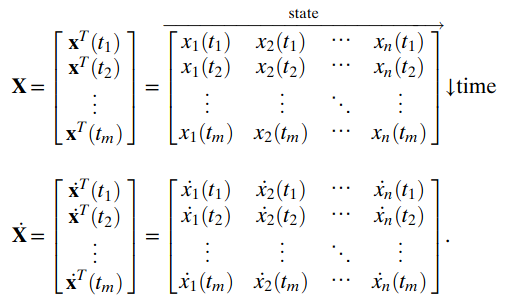


- If measurements of $\mathbf{\dot x}$ are not available, they can be estimated from $\mathbf x$, e.g. via the total-variation regularized derivative (a kind of regularised finite differences).

## Step 2: Construct a Library of Candidate Nonlinear Functions

- Given $\mathbf X$, construct a library of candidate functions $\mathbf{\Theta{(X)}}$,

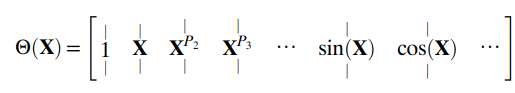

where $\mathbf{X}^{P_i}$ denotes all polynomials of degree $i$, i.e.

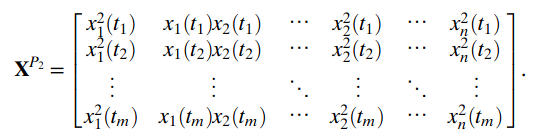

- When constructing $\mathbf{\Theta{(X)}}$, the world is your oyster. Common choices of candidate basis functions would include constant, polynomial, and trigonometric terms, but you can add columns for any functions you like.

## Step 3: Set Up a Sparse Regression Problem

- Given the prior that only a few of the candidate functions will be "active" in each component of $\mathbf{f}$, we can set up the sparse regression problem

$$\mathbf{\dot{X}} = \mathbf{\Theta{(X)}}\mathbf{\Xi},$$

where $\mathbf{\Xi} = [\mathbf{\xi_1} \; \mathbf{\xi_2} \cdots \mathbf{\xi_n}]$ are the sparse coefficients to be determined.

## Step 4: Solve the Sparse Regression Problem

- A common sparse regression method is [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)), which uses an $l_1$ norm, but this may be slow for large amounts of data.
<br>

- Instead, the SINDy authors use a sequentially thresholded least squares algorithm, with the following steps:
    1. Begin with a standard least-squares solution for $\mathbf{\Xi}$.
    2. Set all coefficients with magnitude less than the threshold parameter $\lambda$ equal to zero.
    3. Repeat the least-squares solution on the remaining "active" variables.
    4. Return to step 2 (terminating when the non-zero coefficients have converged).

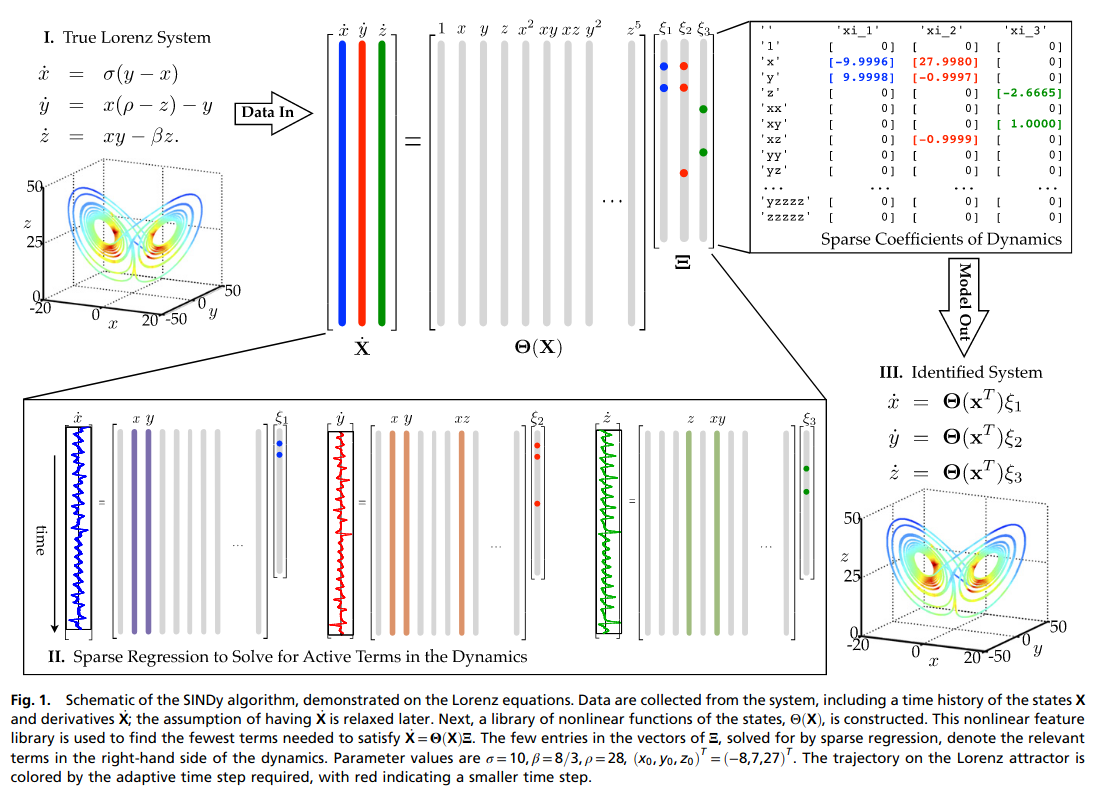

# 2. SINDy Example: Lorenz System <a class="anchor" id="lorenz"></a>

- The Julia package [DataDrivenDiffEq.jl](https://docs.sciml.ai/DataDrivenDiffEq/stable/#DataDrivenDiffEq.jl) provides utilities for estimating models from data.
<br>

- It can be used in combination with the related package [DataDrivenSparse.jl](https://docs.sciml.ai/DataDrivenDiffEq/stable/libs/datadrivensparse/sparse_regression/#DataDrivenSparse) for SINDy.

In [48]:
using OrdinaryDiffEq, DataDrivenDiffEq, DataDrivenSparse, Plots

## Step 1: Set Up the Training Data

In [49]:
function lorenz(u, p, t)
    x, y, z = u

    dx = 10.0 * (y - x)
    dy = x * (28.0 - z) - y
    dz = x * y - (8/3) * z
    
    return [dx, dy, dz]
end

lorenz (generic function with 1 method)

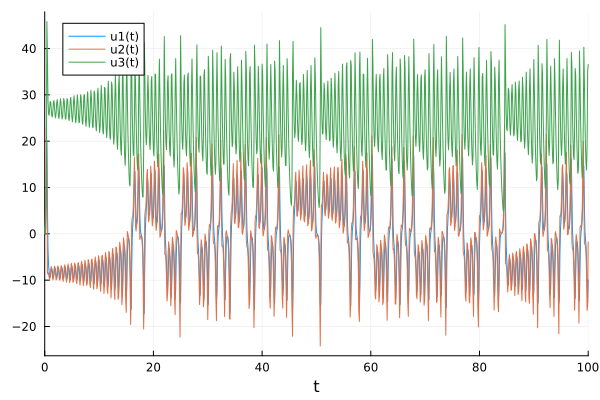

In [50]:
u0 = [1.0, 0.0, 0.0]
tspan = (0.0, 100.0)
dt = 0.1
prob = ODEProblem(lorenz, u0, tspan)
sol = solve(prob, Tsit5(), saveat = dt)
plot(sol)

## Step 2: Set up the Data-Driven Problem Object

In [51]:
ddprob = DataDrivenProblem(sol)

Continuous DataDrivenProblem{Float64} ##DDProblem#635 in 3 dimensions and 1001 samples

## Step 3: Define the Library of Candidate Nonlinear Basis Functions

In [52]:
@variables t x(t) y(t) z(t)  # Symbolic variables
u = [x, y, z]
basis = Basis(polynomial_basis(u, 5), u, iv = t)

Model ##Basis#636 with 56 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (0):

## Step 4: Set Up the Optimiser

In [53]:
optimiser = STLSQ(exp10.(-5:0.1:-1))

STLSQ{Vector{Float64}, Float64}([1.0e-5, 1.2589254117941661e-5, 1.584893192461114e-5, 1.9952623149688786e-5, 2.5118864315095822e-5, 3.1622776601683795e-5, 3.9810717055349695e-5, 5.011872336272725e-5, 6.309573444801929e-5, 7.943282347242822e-5  …  0.012589254117941675, 0.015848931924611134, 0.0199526231496888, 0.025118864315095794, 0.03162277660168379, 0.039810717055349734, 0.05011872336272722, 0.06309573444801933, 0.07943282347242814, 0.1], 0.0)

## Step 5: Solve

In [54]:
ddsol = solve(ddprob, basis, optimiser, options = DataDrivenCommonOptions(digits = 1))

"DataDrivenSolution{Float64}"

In [55]:
ddsol.basis

Model ##Basis#639 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (7):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [56]:
ddsol.prob.p

7-element Vector{Float64}:
 -9.9
 10.0
 27.9
 -0.9
 -0.9
  1.0
 -2.6

$$
\begin{aligned} 
\dot{x} &= \sigma(y-x) \\ 
\dot{y} &= x(\rho-z)  -y \\ 
\dot{z} &= xy - \beta z .
\end{aligned}
$$


# 3. A Harder Example: Estimating the Derivatives of Sparse Time Series with Neural ODEs <a class="anchor" id="neural-odes"></a>

In [57]:
using OrdinaryDiffEq
using Flux
using Zygote
using Optimisers
using SciMLSensitivity
using SymbolicRegression
using Statistics
using Plots

- The SINDy algorithm relies on two important assumptions:
    1. We can either observe the derivatives $\mathbf{\dot x}$, or the observations $\mathbf x$ are sufficiently densely packed that $\mathbf{\dot x}$ can be estimated, e.g. via finite differences.
    2. The underlying equations can be expressed as a linear combination of some pre-selected features.
<br><br>

- To get around the first assumption, we can use $\mathbf x$ to learn some $f = f_{\theta}$ as a neural network, i.e. a neural ODE.
<br>

- To get around the second assumption, we can use a more general symbolic regression algorithm, e.g. the equation search of [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl) which is based on [regularised evolution](https://arxiv.org/abs/1802.01548), a kind of [evolutionary algorithm](https://en.wikipedia.org/wiki/Evolutionary_algorithm).
<br>

- We'll follow the example of [Kidger (2022)](https://arxiv.org/abs/2202.02435) - except we will use multiple orders of magnitude less data - and consider the nonlinear oscillator

$$
\begin{equation}
    \begin{aligned}
        \dot x(t) &= \frac{y(t)}{1+y(t)} \\
        \dot y(t) &= \frac{-x(t)}{1+x(t)},
    \end{aligned}
\end{equation}
$$

for $t \in [0, T]$.

## Step 1: Generate the Training Data

In [58]:
function f(u, p, t)
    x, y = u
    
    dx = y / (1 + y)
    dy = -x / (1 + x)
    
    return [dx, dy]
end

f (generic function with 1 method)

In [66]:
u0 = -0.6f0 .+ (1.6f0 .* rand(Float32, 2))  # Randomly sampled from Uniform[-0.6, 1.0]
tspan = (0f0, 10f0)
dt = 0.1f0
prob = ODEProblem(f, u0, tspan)
sol = solve(prob, Tsit5(); saveat = dt)
ground_truth = Array(sol)

2×101 Matrix{Float32}:
 0.723344  0.74441   0.762724  0.778045  …  -0.493494  -0.469892  -0.441467
 0.288101  0.245769  0.202788  0.159265      0.26166    0.354779   0.438653

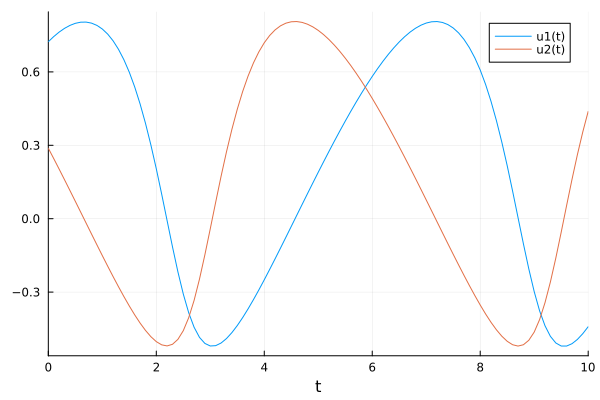

In [67]:
plot(sol)

## Step 2: Set Up the Neural ODE

- Now we need to estimate $f_{\theta}$ in order to find $\dot{\mathbf{x}}$ from $\mathbf{x}$.
<br>

- We'll use a multilayer perceptron with two fully-connected hidden layers with 64 hidden units and ReLU activation functions.

In [68]:
nn = Chain(Dense(2, 64, Flux.relu), Dense(64, 64, Flux.relu), Dense(64, 2))
θ, re = Optimisers.destructure(nn)

(Float32[0.17090343, -0.13481401, -0.29794133, 0.2602468, 0.10185834, -0.027533453, 0.2434137, -0.015075841, 0.23132615, -0.2823423  …  0.019678228, -0.028989142, -0.23870683, -0.1189766, 0.07792188, 0.11982281, -0.22016148, -0.26608104, 0.0, 0.0], Restructure(Chain, ..., 4482))

In [69]:
f_neural(u, θ, t) = re(θ)(u)
prob_neural = ODEProblem(f_neural, u0, tspan, θ)

ODEProblem with uType Vector{Float32} and tType Float32. In-place: false
timespan: (0.0f0, 10.0f0)
u0: 2-element Vector{Float32}:
 0.72334397
 0.28810108

## Step 3: Set Up the Optimiser

- We'll use an Adam optimiser with a constant learning rate of 1e-3.

In [70]:
opt_rule = Optimisers.Adam(1e-3)
opt_state = Optimisers.setup(opt_rule, θ)

Leaf(Adam{Float64}(0.001, (0.9, 0.999), 2.22045e-16), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999)))

## Step 4: Set Up the Loss Function

- We'll use a standard MSE loss function without regularisation.

In [71]:
MSE(ground_truth, predicted) = mean(abs2, ground_truth .- predicted)

MSE (generic function with 1 method)

## Step 5: Train the Neural ODE

- Unlike most of the time series we've dealt with during this lecture course, the nonlinear oscillator isn't chaotic, so we can probably take gradients through the entire trajectory without any issues.
<br>

- Different initialisations of the neural network weights can lead to different results for this procedure. If you can't get the training loss to $\mathcal{O}(10^{-5})$, try:
    1. Training for more iterations.
    2. Re-initialising the neural network weights and starting again.
    3. Training on a small portion of the time series first before moving on to the entire time series.

In [74]:
n_iters = 5_000

5000

In [75]:
for i in 1:n_iters    
    training_loss, gradients = Zygote.withgradient(θ) do θ
        sol_neural = solve(prob_neural, Tsit5(), saveat = sol.t, p = θ)
        predicted = Array(sol_neural)
        return MSE(ground_truth, predicted)
    end
        
    Optimisers.update!(opt_state, θ, gradients[1])
    
    if (i % 100) == 0
        @info "Epoch = $(i), training loss = $(training_loss)"
    end
end

┌ Info: Epoch = 100, training loss = 0.11223302
└ @ Main In[75]:11
┌ Info: Epoch = 200, training loss = 0.10879475
└ @ Main In[75]:11
┌ Info: Epoch = 300, training loss = 0.1875437
└ @ Main In[75]:11
┌ Info: Epoch = 400, training loss = 0.030893281
└ @ Main In[75]:11
┌ Info: Epoch = 500, training loss = 0.011764248
└ @ Main In[75]:11
┌ Info: Epoch = 600, training loss = 0.002627652
└ @ Main In[75]:11
┌ Info: Epoch = 700, training loss = 0.0013160087
└ @ Main In[75]:11
┌ Info: Epoch = 800, training loss = 0.00063167093
└ @ Main In[75]:11
┌ Info: Epoch = 900, training loss = 0.0004538318
└ @ Main In[75]:11
┌ Info: Epoch = 1000, training loss = 0.00040159805
└ @ Main In[75]:11
┌ Info: Epoch = 1100, training loss = 0.00025991205
└ @ Main In[75]:11
┌ Info: Epoch = 1200, training loss = 0.0001951928
└ @ Main In[75]:11
┌ Info: Epoch = 1300, training loss = 0.00039978093
└ @ Main In[75]:11
┌ Info: Epoch = 1400, training loss = 0.00015171016
└ @ Main In[75]:11
┌ Info: Epoch = 1500, training los

score = log2(loss) + complexity

In [76]:
1

1

In [77]:
1+1

2

In [ ]:
cos(x)

## Step 6: Use the Neural ODE to Predict $\dot{\mathbf{X}}$

In [79]:
x = ground_truth

2×101 Matrix{Float32}:
 0.723344  0.74441   0.762724  0.778045  …  -0.493494  -0.469892  -0.441467
 0.288101  0.245769  0.202788  0.159265      0.26166    0.354779   0.438653

In [80]:
mlp = re(θ)
dx = mapslices(mlp, x, dims = 1)

2×101 Matrix{Float32}:
  0.232467   0.217937   0.197897   0.149615  …  0.235179  0.273783  0.305952
 -0.433224  -0.439745  -0.444118  -0.441518     0.999828  0.938803  0.844235

## Step 7: Use [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl) to Find the Equation

- First we set up the options for the equation search. To keep things simple for the lecture, we limit ourselves to basic binary operations.
<br>

- See [here](https://astroautomata.com/SymbolicRegression.jl/stable/api/#Options) for a full specification of the possible options.

In [63]:
options = SymbolicRegression.Options(
    binary_operators=[+, *, /, -],
    unary_operators=[],
)

Options(
    # Operators:
        binops=Function[+, *, /, -], unaops=Function[],
    # Loss:
        loss=L2DistLoss,
    # Complexity Management:
        maxsize=20, maxdepth=20, bin_constraints=[(-1, -1), (-1, -1), (-1, -1), (-1, -1)], una_constraints=Int64[], use_frequency=true, use_frequency_in_tournament=true, parsimony=0.0032, warmup_maxsize_by=0.0, 
    # Search Size:
        npopulations=15, ncycles_per_iteration=550, npop=33, 
    # Migration:
        migration=true, hof_migration=true, fraction_replaced=0.00036, fraction_replaced_hof=0.035,
    # Tournaments:
        prob_pick_first=0.86, tournament_selection_n=12, topn=12, 
    # Constant tuning:
        perturbation_factor=0.076, probability_negate_constant=0.01, should_optimize_constants=true, optimizer_algorithm=BFGS, optimizer_probability=0.14, optimizer_nrestarts=2, optimizer_iterations=8,
    # Mutations:
        mutation_weights=MutationWeights(0.048, 0.47, 0.79, 5.1, 1.7, 0.002, 0.00023, 0.21, 0.0), crossover_probab

- Given the options we perform the equation search. 
<br>

- The results are stored in a `HallOfFame` object, which records the best equations seen during the equation search.

In [81]:
hall_of_fame = EquationSearch(
    x,
    dx,
    niterations=100, 
    options=options,
    parallelism=:multithreading,
)

Started!

Cycles per second: 1.640e+05
Head worker occupation: 4.4%
Progress: 451 / 3000 total iterations (15.033%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           6.758e-02  1.301e+00  x2
3           2.965e-02  4.120e-01  (x2 + -0.19477032)
5           2.162e-04  2.461e+00  (x2 / (x2 + 0.9986154))
7           2.113e-04  1.129e-02  ((x2 - -0.0027560417) / (x2 + 0.9964929))
9           2.100e-04  3.075e-03  (x2 / (((x2 * 0.9850671) + 1.1182245) - 0.12628575))
13          2.092e-04  1.016e-03  ((x2 - ((-0.00067084405 / (x2 + -0.049208205)) * x2)) / (x2 + 0.9986154))
17          2.041e-04  6.110e-03  (x2 / ((x2 - ((x2 / ((x2 - (x2 * -0.060559742)) + 1.1175356)) * 0.016587364)) + 0.9860088))
19          2.019e-04  5.512e-03  ((x2 / (x2 + 0.9986154)) + (((-1.225408 - (x2 / -0.24816738)) * x2) * (2.474916 / (230.01738 / x1))))
21          1.987e-04  8.095e-03  ((x2 / (x2 + 0.9986154)) + ((((x1 + -1.6349


Cycles per second: 1.460e+05
Head worker occupation: 4.5%
Progress: 2031 / 3000 total iterations (67.700%)
Best equations for output 1
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           6.758e-02  1.301e+00  x2
3           2.965e-02  4.120e-01  (x2 + -0.19477032)
5           2.162e-04  2.461e+00  (x2 / (x2 + 0.9986154))
7           2.099e-04  1.471e-02  ((x2 / (x2 + 0.99729735)) + 0.0027545162)
9           2.089e-04  2.418e-03  ((-1.0048307 / ((x2 / x2) + x2)) - -1.0071211)
11          1.925e-04  4.076e-02  (x2 / ((x2 + (-0.0012436132 / (x1 + 0.53092664))) + 0.99923545))
13          1.812e-04  3.020e-02  ((x2 - -0.0032164871) / ((x2 + (-0.0012436132 / (x1 + 0.53092664))) + 0.99923545))
15          1.756e-04  1.594e-02  ((x2 - -0.0032164871) / ((x2 + ((-0.0012436132 / 0.6895672) / (x1 + 0.53092664))) + 0.99923545))
19          1.688e-04  9.842e-03  ((x2 - (-0.00044650192 / ((-0.5451561 / x1) + -1.0270828))) / ((x2 + (-0.0011628

2-element Vector{HallOfFame{Float32}}:
 HallOfFame{Float32}(PopMember{Float32}[PopMember{Float32}(x2, 0.27545205f0, 0.06758406f0, 16752465060508180, 307647029797667119, 6003368864276835586), PopMember{Float32}(1.0, 0.0f0, Inf32, 16752465060500020, 2862880936303194559, -1), PopMember{Float32}((x2 + -0.19477032), 0.12902501f0, 0.029646158f0, 16752465063467100, 212749990691464495, 5822412950663887381), PopMember{Float32}(1.0, 0.0f0, Inf32, 16752465060500030, 7019345370553458779, -1), PopMember{Float32}((x2 / (x2 + 0.9986154)), 0.016870763f0, 0.00021615924f0, 16752465083436850, 826616606777690115, 6213073271099088111), PopMember{Float32}(1.0, 0.0f0, Inf32, 16752465060500030, 4220304826052750576, -1), PopMember{Float32}(((x2 / (x2 + 0.99729735)) + 0.0027545162), 0.023245512f0, 0.00020989058f0, 16752465311271720, 8889000140821760705, 2115594442198208559), PopMember{Float32}(1.0, 0.0f0, Inf32, 16752465060500030, 8330873284130798020, -1), PopMember{Float32}(((x2 + 0.0017085664) / ((x2 * 0.9895

- Given the "hall of fame", calculate the Pareto frontier for each equation, i.e. the best solution at each level of complexity.

In [83]:
pareto1 = calculate_pareto_frontier(x, dx[1, :], hall_of_fame[1], options)
pareto1[3].tree

(x2 / (x2 + 0.9986154))

In [84]:
pareto2 = calculate_pareto_frontier(x, dx[2, :], hall_of_fame[2], options)
pareto2[3].tree

(x1 / (-1.0027133 - x1))

- Just like that, we've recovered the equations for the nonlinear oscillator!

## Step 8 (just for fun): More Gradient Descent to Refine the Parameters...?

- In Kidger's example, he now does another round of gradient descent on the coefficients found by the symbolic regression in order to fine-tune them further.
<br>

- Our results are already extremely accurate, but if you really wanted to, this is how you'd do it...

In [86]:
function f_symbolic(u, p, t)
    x, y = u
    a, b = p
    
    dx = y / (a + y)
    dy = -x / (b + x)
    
    return [dx, dy]
end

f_symbolic (generic function with 1 method)

In [87]:
# Use 64-bit arithmetic for more precision
p = [0.9986154, 1.0027133]
u0_64 = Float64.(u0)
tspan_64 = Float64.(tspan)
prob_symbolic = ODEProblem(f_symbolic, u0_64, tspan_64, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 0.7233439683914185
 0.28810107707977295

In [96]:
opt_rule = Optimisers.Adam(1e-1)
opt_state = Optimisers.setup(opt_rule, p)

Leaf(Adam{Float64}(0.1, (0.9, 0.999), 2.22045e-16), ([0.0, 0.0], [0.0, 0.0], (0.9, 0.999)))

In [ ]:
for i in 1:10_000
    training_loss, gradients = Zygote.withgradient(p) do p
        predicted = Array(solve(prob_symbolic, Tsit5(), saveat = sol.t, p = p))
        return MSE(ground_truth, predicted)
    end
        
    Optimisers.update!(opt_state, p, gradients[1])
    
    if (i % 200) == 0
        @info "Epoch = $(i), training loss = $(training_loss)"
        @info p
    end
end

# 4. Reminder: Teaching Evaluations <a class="anchor" id="reminder"></a>

- Your feedback is invaluable to us. **Please fill out the teaching evaluations!**
<br>

- The deadline has been extended to **10/02/2023** (but please do it ASAP).
<br>

- If you can no longer find the TAN number from the original email you received about the teaching evaluations, please let us know and we'll give you a new one.
<br>

- **Please only fill out the feedback for the lecture, not the exercise!**

# 5. Further Reading <a class="anchor" id="further-reading"></a>
1. [Discovering governing equations from data by sparse identification of nonlinear dynamical systems (Brunton et al. 2016)](https://www.pnas.org/doi/10.1073/pnas.1517384113)
2. [Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (Brunton et al. 2019)](https://www.cambridge.org/core/books/datadriven-science-and-engineering/77D52B171B60A496EAFE4DB662ADC36E)
3. [YouTube Videos on SINDy](https://www.youtube.com/watch?v=NxAn0oglMVw)
4. [DataDrivenDiffEq.jl](https://github.com/SciML/DataDrivenDiffEq.jl)
5. [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl)